In [3]:
# importing necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
#unzip dataset
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/cats_vs_dogs_small.zip" -d /content/

Mounted at /content/drive


In [5]:
#Define dataset path
base_dir = "/content/cats_vs_dogs_small"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

print(" Dataset folders found:")
print("Train:", os.listdir(train_dir))
print("Validation:", os.listdir(val_dir))
print("Test:", os.listdir(test_dir))

 Dataset folders found:
Train: ['cats', 'dogs']
Validation: ['cats', 'dogs']
Test: ['cats', 'dogs']


In [6]:
def remove_corrupted_files(directory):
    deleted = 0
    for subfolder in ["cats", "dogs"]:
        path = os.path.join(directory, subfolder)
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                deleted += 1
    print(f" Cleaned {deleted} corrupted or unreadable images from {directory}")

for folder in [train_dir, val_dir, test_dir]:
    remove_corrupted_files(folder)

 Cleaned 0 corrupted or unreadable images from /content/cats_vs_dogs_small/train
 Cleaned 0 corrupted or unreadable images from /content/cats_vs_dogs_small/validation
 Cleaned 0 corrupted or unreadable images from /content/cats_vs_dogs_small/test


In [7]:
img_size = (180, 180)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

In [10]:
#  CNN Model
from tensorflow import keras
cnn_model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_scratch = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.5064 - loss: 0.7786 - val_accuracy: 0.5260 - val_loss: 0.6916
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5375 - loss: 0.6859 - val_accuracy: 0.5600 - val_loss: 0.6786
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5758 - loss: 0.6848 - val_accuracy: 0.5970 - val_loss: 0.6672
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6094 - loss: 0.6699 - val_accuracy: 0.6430 - val_loss: 0.6383
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6443 - loss: 0.6315 - val_accuracy: 0.6650 - val_loss: 0.6137
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6799 - loss: 0.5899 - val_accuracy: 0.6390 - val_loss: 0.6393
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6827 - loss: 0.5861 - val_accuracy: 0.6850 - val_loss: 0.5890
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6832 - loss: 0.5670 - val_accuracy: 0.6670 

In [12]:
cnn_model.evaluate(val_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7375 - loss: 0.5394


[0.5461403131484985, 0.718999981880188]

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(180,180,3))

for layer in vgg_base.layers:
    layer.trainable = False

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_base(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs, outputs)
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  1,638,528 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,353,345 (62.38 MB)

 Trainable params: 1,638,657 (6.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
history_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.8515 - loss: 3.4609 - val_accuracy: 0.9550 - val_loss: 0.7992
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9447 - loss: 0.8155 - val_accuracy: 0.9670 - val_loss: 0.2787
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9607 - loss: 0.2581 - val_accuracy: 0.9650 - val_loss: 0.2019
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9591 - loss: 0.2823 - val_accuracy: 0.9790 - val_loss: 0.0956
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9718 - loss: 0.0866 - val_accuracy: 0.9760 - val_loss: 0.1292


In [15]:
print(" CNN Model:")
cnn_model.evaluate(test_ds)
print(" VGG16 Pretrained Model:")
vgg_model.evaluate(test_ds)


 CNN Model:
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6749 - loss: 0.5996
 VGG16 Pretrained Model:
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9706 - loss: 0.2250


[0.20270410180091858, 0.968999981880188]

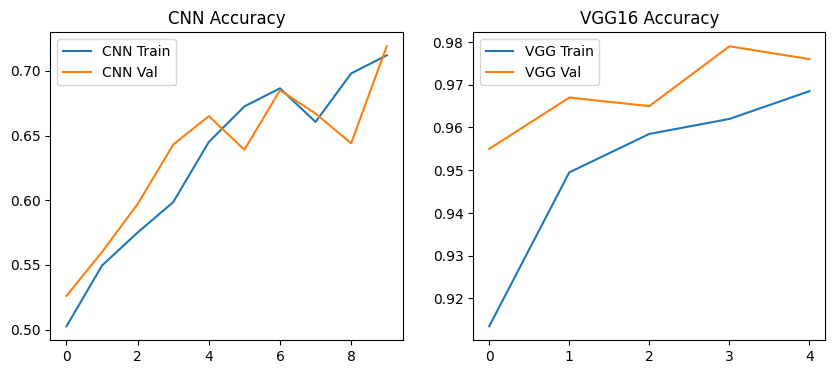

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_scratch.history['accuracy'], label='CNN Train')
plt.plot(history_scratch.history['val_accuracy'], label='CNN Val')
plt.legend(); plt.title('CNN Accuracy')

plt.subplot(1,2,2)
plt.plot(history_vgg.history['accuracy'], label='VGG Train')
plt.plot(history_vgg.history['val_accuracy'], label='VGG Val')
plt.legend(); plt.title('VGG16 Accuracy')
plt.show()